### Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
import sklearn
import timeit
import seaborn as sns
import os
from pathlib import Path

dataPath = str(Path(os.getcwd()).parent.absolute())+"/data"
figuresPath = str(Path(os.getcwd()).parent.absolute())+"/reports/figures"

In [25]:
GMB_MKT_daily = pd.read_csv(dataPath+'/interim/marketGreenPortfolios.csv', index_col=0).loc[:,["MKT_GMB_BL|DAILY_RETURNS","MKT_GMB_RO|DAILY_RETURNS","MKT_GMB|DAILY_RETURNS"]]
# GMB_MKT_daily.head()
GMB_INDW_daily = pd.read_csv(dataPath+'/interim/industryWeightedGreenPortfolios.csv', index_col=0)[["IND_W_GMB_BL|DAILY_RETURNS","IND_W_GMB_RO|DAILY_RETURNS","IND_W_GMB|DAILY_RETURNS"]]
#  GMB_INDW_daily.head()
MKT_daily = pd.read_csv(dataPath+'/interim/marketData.csv', index_col=0)["MKT|DAILY_RETURNS"]
# MKT_daily.head()
STOCKS_daily = pd.read_csv(dataPath+'/raw/stocksData.csv', index_col=0) 
#  STOCKS_daily.head()
FF_daily = pd.read_csv(dataPath+'/raw/ffData.csv', index_col=0)
# ff_ret.head()


In [26]:
merged=pd.concat([FF_daily,GMB_MKT_daily,GMB_INDW_daily,MKT_daily],axis=1)
merged=merged.dropna()# drops the first row which contains NaN
# merged.head()

In [27]:
GMB_porfolios = ["MKT_GMB_BL|DAILY_RETURNS","MKT_GMB_RO|DAILY_RETURNS","MKT_GMB|DAILY_RETURNS","IND_W_GMB_BL|DAILY_RETURNS","IND_W_GMB_RO|DAILY_RETURNS","IND_W_GMB|DAILY_RETURNS"]
regressionResults = pd.DataFrame(columns=GMB_porfolios)

In [28]:
for portfolio in GMB_porfolios:
    X = merged[['Mkt-RF','SMB','HML','RMW','CMA']]
    X1= sm.add_constant(X)   
    y = merged[portfolio]
    print(X1)
    print(y)
    break

            const  Mkt-RF   SMB   HML   RMW   CMA
2016-09-14    1.0   -0.08  0.06 -0.81  0.09 -0.45
2016-09-15    1.0    1.08  0.30 -0.32  0.06 -0.21
2016-09-16    1.0   -0.36  0.29 -0.45  0.21 -0.19
2016-09-19    1.0    0.05  0.51  0.15 -0.08  0.36
2016-09-20    1.0   -0.02 -0.35 -0.41 -0.55 -0.10
...           ...     ...   ...   ...   ...   ...
2022-10-25    1.0    1.78  1.02 -1.52 -1.16 -1.23
2022-10-26    1.0   -0.66  0.69  0.89 -0.81  0.69
2022-10-27    1.0   -0.54  0.43  1.06 -0.38  0.51
2022-10-28    1.0    2.33  0.05 -0.34  0.38  0.60
2022-10-31    1.0   -0.67  0.47  0.75 -0.21  0.48

[1544 rows x 6 columns]
2016-09-14   -0.076413
2016-09-15   -0.189474
2016-09-16    0.306634
2016-09-19   -0.073496
2016-09-20    0.001607
                ...   
2022-10-25   -0.514384
2022-10-26    0.109475
2022-10-27   -0.551825
2022-10-28   -0.385253
2022-10-31    0.074329
Name: MKT_GMB_BL|DAILY_RETURNS, Length: 1544, dtype: float64


In [29]:
for portfolio in GMB_porfolios:
    X = merged[['Mkt-RF','SMB','HML','RMW','CMA']]
    X1= sm.add_constant(X)   
    y = merged[portfolio]
    FF5= sm.OLS(y,X1).fit()
    summary= pd.DataFrame(data=FF5.summary2().tables[1][["Coef.","Std.Err.","P>|t|"]].stack())
    summary = pd.concat([summary,pd.DataFrame(index=[["R-squared","F-statistic"],["-","-"]], data=[FF5.rsquared,FF5.fvalue])],axis=0)
    regressionResults[portfolio]=summary
        



In [30]:
regressionResults

MKT_GMB_BL|DAILY_RETURNS  MKT_GMB_RO|DAILY_RETURNS  \
const       Coef.                -6.190015e-03             -3.299255e-03   
            Std.Err.              8.177417e-03              5.853082e-03   
            P>|t|                 4.491870e-01              5.730554e-01   
Mkt-RF      Coef.                -5.200545e-02             -4.502535e-02   
            Std.Err.              6.885238e-03              4.928190e-03   
            P>|t|                 7.248084e-14              1.979873e-19   
SMB         Coef.                -4.641943e-02             -1.287871e-01   
            Std.Err.              1.324657e-02              9.481387e-03   
            P>|t|                 4.710021e-04              8.990121e-40   
HML         Coef.                -1.645980e-01             -1.644052e-01   
            Std.Err.              1.183706e-02              8.472519e-03   
            P>|t|                 1.706840e-41              3.334403e-75   
RMW         Coef.                 2.566736e-02              5.742748e-02   
            Std.Err.              1.694242e-02              1.212674e-02   
            P>|t|                 1.299840e-01              2.385089e-06   
CMA         Coef.                 4.016416e-01              1.150285e-01   
            Std.Err.              2.264251e-02              1.620664e-02   
            P>|t|                 3.374908e-64              1.931251e-12   
R-squared   -                     2.885240e-01              4.461509e-01   
F-statistic -                     1.247407e+02              2.477859e+02   

                      MKT_GMB|DAILY_RETURNS  IND_W_GMB_BL|DAILY_RETURNS  \
const       Coef.             -4.744635e-03               -4.968787e-03   
            Std.Err.           5.779212e-03                7.674207e-03   
            P>|t|              4.117832e-01                5.174271e-01   
Mkt-RF      Coef.             -4.851540e-02                4.741079e-02   
            Std.Err.           4.865992e-03                6.461544e-03   
            P>|t|              9.896760e-23                3.511272e-13   
SMB         Coef.             -8.760324e-02               -9.973411e-03   
            Std.Err.           9.361724e-03                1.243142e-02   
            P>|t|              2.786577e-20                4.225181e-01   
HML         Coef.             -1.645016e-01                8.541223e-02   
            Std.Err.           8.365589e-03                1.110865e-02   
            P>|t|              5.677836e-77                2.633212e-14   
RMW         Coef.              4.154742e-02                2.115289e-02   
            Std.Err.           1.197369e-02                1.589984e-02   
            P>|t|              5.350464e-04                1.835892e-01   
CMA         Coef.              2.583350e-01                4.080265e-02   
            Std.Err.           1.600210e-02                2.124917e-02   
            P>|t|              2.796988e-54                5.501742e-02   
R-squared   -                  4.134326e-01                1.260941e-01   
F-statistic -                  2.168069e+02                4.438299e+01   

                      IND_W_GMB_RO|DAILY_RETURNS  IND_W_GMB|DAILY_RETURNS  
const       Coef.                  -5.908170e-03            -5.438479e-03  
            Std.Err.                7.280677e-03             5.888052e-03  
            P>|t|                   4.172120e-01             3.558153e-01  
Mkt-RF      Coef.                   1.059214e-03             2.423500e-02  
            Std.Err.                6.130199e-03             4.957634e-03  
            P>|t|                   8.628421e-01             1.122776e-06  
SMB         Coef.                  -1.631621e-01            -8.656777e-02  
            Std.Err.                1.179394e-02             9.538034e-03  
            P>|t|                   4.109228e-41             3.351897e-19  
HML         Coef.                  -2.466352e-03             4.147294e-02  
            S

In [31]:
merged.drop(columns="RF").corr().to_csv(dataPath+"/processed/GMBCorrelationResults.csv") 

#Calculating GMB contribution with shapley values

In [32]:
STOCKS_daily = pd.read_csv(dataPath+'/raw/stocksData.csv', index_col=0) [[col for col in STOCKS_daily.columns if 'DAILY_RETURNS' in col]]
#STOCKS_daily.head()

In [33]:
merged=pd.concat([FF_daily,GMB_INDW_daily,STOCKS_daily],axis=1)
merged=merged.dropna().rename(columns={'IND_W_GMB|DAILY_RETURNS': 'GMB'})
# merged.head()

In [34]:
#compute the mean SHAP values for the linear model for each stock and plot the median of all the SHAP values contribution to the overall regression

i=0
GMBfactors=[]
shapValues= pd.DataFrame(columns=["Mkt-RF","SMB","HML","RMW","CMA","GMB"])
# shapValues2= pd.DataFrame(columns=["Mkt-RF","SMB","HML","RMW","CMA","GMB"])
for stock in STOCKS_daily: 

    X = merged[["Mkt-RF","SMB","HML","RMW","CMA","GMB"]]
    y = merged[stock]-merged["RF"]
    model = sklearn.linear_model.LinearRegression().fit(X, y)
    r2=sklearn.metrics.r2_score(y, model.predict(X))
    GMBfactors+=[model.coef_[5]]


    # compute the SHAP values for the linear model for the stock
    explainer = shap.LinearExplainer(model, X)
    shap_values = explainer(X)
    
    #calculate the contribution of each explanatory variable to the overall R2 for of each regression
    #total contribution to the overall regression = shapValues.abs().mean() / (shapValues.abs().mean().sum())   *  r2
    
    shap_values_contrib = pd.DataFrame(data=shap_values.values,columns=["Mkt-RF","SMB","HML","RMW","CMA","GMB"])
    shap_values_contrib =  (shap_values_contrib.abs().mean())/(shap_values_contrib.abs().mean().sum())*r2
    
    # take the SHAP values contributions and concat them the df of all stock SHAP values contributions
    shapValues = pd.concat([shapValues,pd.DataFrame(data=shap_values_contrib).transpose()])
    
#     shap.plots.bar(shap_values)
#     i+=1
#     if i==10:break




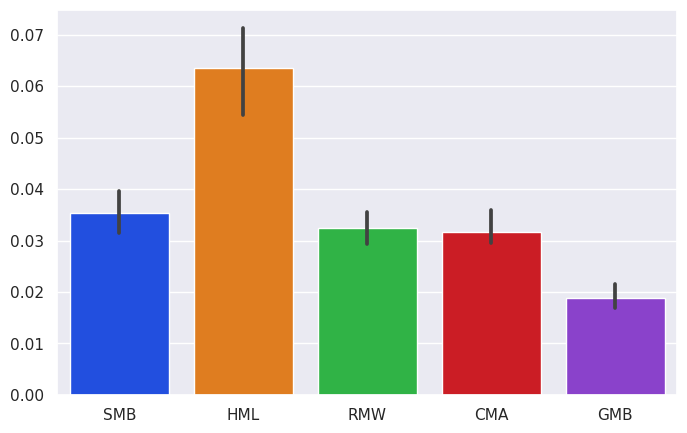

In [35]:
sns.set(rc={"figure.figsize":(8, 5)})
sns_plot = sns.barplot(data=shapValues.drop(columns="Mkt-RF"), palette="bright",estimator=np.median)
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/shapValues.png")

Ignoring `palette` because no `hue` variable has been assigned.


AttributeError: 'list' object has no attribute 'savefig'

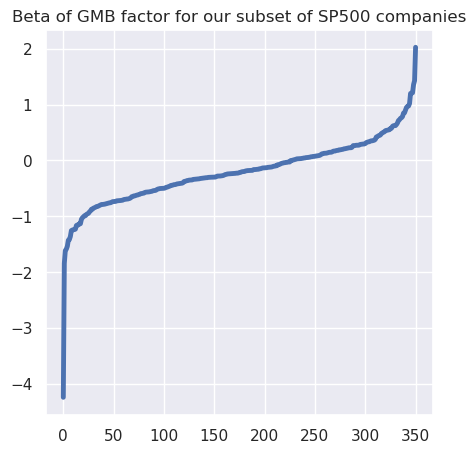

In [17]:
sns.set(rc={"figure.figsize":(5, 5)})
sns_plot = sns.lineplot(data=sorted(GMBfactors), palette="bright",linewidth=3.5).set(title="Beta of GMB factor for our subset of SP500 companies")
#fig = sns_plot.get_figure()
#sns_plot .savefig(figuresPath+"GMBFactor.png")